In [22]:
import h5py, os
import numpy as np
from tqdm import tqdm

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

# find sobol indices closest to Buzzard cosmology

In [23]:
meta_file = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/data/CosmoGridV1_metainfo.h5"
with h5py.File(meta_file, "r") as f:
    print(f.keys())
    print(f["parameters"].keys())

    grid_params = f["parameters/grid"][:]

<KeysViewHDF5 ['parameters', 'shell_info', 'simulations']>
<KeysViewHDF5 ['all', 'benchmark', 'fiducial', 'grid']>


In [24]:
buzzard_cosmo = np.array([0.286, 0.82, -1]) # h = 0.7, ns = 0.96, Omega_b = 0.046 
i_sobols = grid_params["sobol_index"]

cosmo_params = ["Om", "s8", "w0"]
grid_cosmo = np.stack([grid_params[param] for param in cosmo_params], axis=-1)

param_min = grid_cosmo.min(axis=0)
param_max = grid_cosmo.max(axis=0)
grid_cosmo_normalized = (grid_cosmo - param_min) / (param_max - param_min)

buzzard_cosmo_normalized = (buzzard_cosmo - param_min) / (param_max - param_min)

In [25]:
# distances = np.linalg.norm(grid_cosmo_normalized - buzzard_cosmo_normalized, axis=1)
distances = np.linalg.norm(grid_cosmo - buzzard_cosmo, axis=1)

n = 5
closest_indices = np.argsort(distances)[:n]
closest_sobols = i_sobols[closest_indices]
closest_points = grid_cosmo[closest_indices]

print("closest", n, "points:\n", closest_points)
print("distances", distances[closest_indices])
print("indices:", closest_indices)
print("i_sobols:", closest_sobols)

closest 5 points:
 [[ 0.28362122  0.83476105 -1.0074589 ]
 [ 0.30283051  0.83092728 -0.99843534]
 [ 0.27389526  0.8223175  -0.9670023 ]
 [ 0.26190033  0.84841385 -0.99930017]
 [ 0.28247681  0.81880798 -0.96094844]]
distances [0.01670875 0.02012758 0.03522419 0.03726434 0.03922828]
indices: [1954 2307 1483 2380 1585]
i_sobols: [114996 172798  40100 184644  57908]


In [26]:
print(grid_params["ns"][closest_indices])
print(grid_params["Ob"][closest_indices])
print(grid_params["H0"][closest_indices])

[0.98624603 0.99486038 0.97454407 0.97588455 0.9475238 ]
[0.04262169 0.04872334 0.04701462 0.04199146 0.04603592]
[65.9026947  65.26734161 68.5887146  68.4275589  73.12661743]


# load Buzzard $C_\ell$ best fit

In [41]:
def get_MAP(obs_label):
    chain = np.load(os.path.join(cls_dir, f"chain_{obs_label}.npy"))
    log_probs = np.load(os.path.join(cls_dir, f"log_probs_{obs_label}.npy"))
    
    MAP_params = chain[np.argmax(log_probs)]
    MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}

    return [MAP_dict[bg] for bg in bgs]

In [42]:
cls_dir =  "/pscratch/sd/a/athomsen/run_files/v14/cls/lensing=False,clustering=True,standard=False,log=True,cosine=False,steps=400000/32mpc_sigmoid/likelihood_flow"
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]
bgs = [f"bg{i}" for i in range(1,5)]

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
tomo_bg_single_buzzard = []
for i in buzzard_indices:
    tomo_bg_single_buzzard.append(get_MAP(f"Buzzard_{i}"))
    
tomo_bg_buzzard_flock = np.stack(tomo_bg_single_buzzard, axis=0)
print(tomo_bg_buzzard_flock)

[[0.893 1.034 1.087 1.145]
 [1.261 1.516 1.59  1.656]
 [0.962 1.1   1.161 1.259]
 [1.115 1.252 1.351 1.376]
 [1.828 2.079 2.258 2.292]
 [1.119 1.302 1.406 1.456]
 [2.485 2.756 2.948 2.968]
 [1.624 1.858 1.954 2.031]
 [0.909 1.042 1.083 1.132]
 [0.924 1.076 1.137 1.2  ]
 [0.996 1.141 1.245 1.309]
 [1.094 1.276 1.313 1.371]
 [1.776 2.011 2.12  2.163]
 [1.051 1.225 1.348 1.414]
 [1.113 1.312 1.375 1.404]]


In [44]:
tomo_bg_buzzard_mean = get_MAP("Buzzard_mean")
print(tomo_bg_buzzard_mean)

[1.127, 1.303, 1.37, 1.454]


In [45]:
tomo_bg_buzzard_stack = get_MAP("Buzzard_stack")
print(tomo_bg_buzzard_stack)

[1.128, 1.313, 1.401, 1.447]


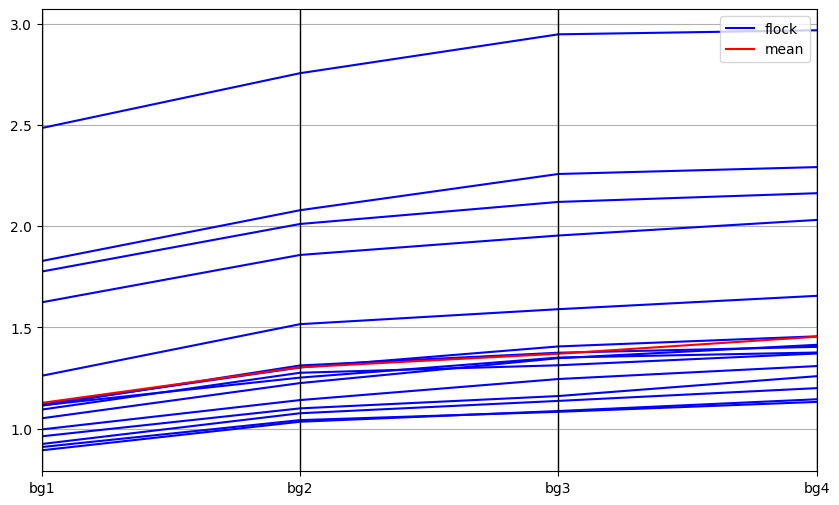

In [47]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

df = pd.DataFrame(tomo_bg_buzzard_flock, columns=bgs)
df['label'] = 'flock'
point_df = pd.DataFrame([tomo_bg_buzzard_mean], columns=bgs)
point_df['label'] = 'mean'
full_df = pd.concat([df, point_df], ignore_index=True)

plt.figure(figsize=(10, 6))
parallel_coordinates(full_df, 'label', color=['blue', 'red'])
plt.grid(True)
plt.show()

In [48]:
# tomo_bg_buzzard = tomo_bg_buzzard_mean
# i_buzzard = 3
# i_buzzard = 7
# tomo_bg_buzzard = tomo_bg_buzzard_flock[i_buzzard]
# tomo_bg_buzzard = [2.5]*4

# tomo_bg_buzzard = tomo_bg_buzzard_mean
tomo_bg_buzzard = tomo_bg_buzzard_stack

print(tomo_bg_buzzard)

[1.128, 1.313, 1.401, 1.447]


# forward model maps according to Buzzard $C_\ell$ best fit

In [49]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)
cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid"
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

with_lensing = False
with_clustering = True

25-06-10 05:15:02 configuratio INF   Loaded the config 


In [50]:
closest_sobol = closest_sobols[0]
cosmo_dir = os.path.join(cosmogrid_dir, f"cosmo_{closest_sobol:06d}")

cosmogrid_cls = []
for i in tqdm(range(20)):
    perm_dir = os.path.join(cosmo_dir, f"perm_{i:04d}")

    wl_gamma_patch, gc_count_patch = observation.forward_model_cosmogrid(
        perm_dir,
        conf=msfm_conf,
        noisy=True,
        # lensing
        with_lensing=with_lensing,
        tomo_Aia=None,
        bta=None,
        i_sobol=closest_sobol,
        # clustering
        with_clustering=with_clustering,
        tomo_bg=tomo_bg_buzzard,
        noise_seed=12,
    )

    obs_map, obs_cls_raw, footprint_pix = observation.forward_model_observation_map(
        wl_gamma_map=wl_gamma_patch,
        gc_count_map=gc_count_patch,
        conf=msfm_conf,
        # apply_norm=True,
        apply_norm=False,
        with_padding=True,
        nest_in=False,
    )

    if not (with_lensing and with_clustering):
        obs_cls_full = np.zeros((obs_cls_raw.shape[0], 36))

        bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
            with_lensing=with_lensing,
            with_clustering=with_clustering,
            with_cross_z=True,
        )
        
        obs_cls_full[:,bin_indices] = obs_cls_raw

    obs_cls = preprocessing.get_preprocessed_cl_observation(
        obs_cl=obs_cls_full,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        with_cross_probe=(with_lensing and with_clustering),
        # additional preprocessing
        apply_log=False,
        standardize=False,
        # plotting
        make_plot=False,
    )

    cosmogrid_cls.append(obs_cls)

cosmogrid_cls = np.concatenate(cosmogrid_cls, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

25-06-10 05:15:02 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0000/projected_probes_maps_v11dmb.h5 
25-06-10 05:15:24 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:15:24 observation. INF   No quadratic biasing 
25-06-10 05:15:25 observation. INF   Finished galaxy clustering after 0:00:23.00 
25-06-10 05:15:30 configuratio INF   Loaded the config 
25-06-10 05:15:30 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:15:30 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:15:30 preprocessin INF   Adding white noise to the observation 
25-06-10 05:15:30 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


  5%|▌         | 1/20 [00:28<09:00, 28.44s/it]

25-06-10 05:15:30 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0001/projected_probes_maps_v11dmb.h5 
25-06-10 05:15:53 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:15:53 observation. INF   No quadratic biasing 
25-06-10 05:15:53 observation. INF   Finished galaxy clustering after 0:00:22.64 
25-06-10 05:15:58 configuratio INF   Loaded the config 
25-06-10 05:15:58 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:15:58 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:15:58 preprocessin INF   Adding white noise to the observation 
25-06-10 05:15:58 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 10%|█         | 2/20 [00:56<08:28, 28.27s/it]

25-06-10 05:15:59 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0002/projected_probes_maps_v11dmb.h5 
25-06-10 05:16:21 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:16:21 observation. INF   No quadratic biasing 
25-06-10 05:16:22 observation. INF   Finished galaxy clustering after 0:00:23.48 
25-06-10 05:16:27 configuratio INF   Loaded the config 
25-06-10 05:16:27 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:16:27 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:16:27 preprocessin INF   Adding white noise to the observation 
25-06-10 05:16:27 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 15%|█▌        | 3/20 [01:25<08:05, 28.58s/it]

25-06-10 05:16:27 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0003/projected_probes_maps_v11dmb.h5 
25-06-10 05:16:50 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:16:50 observation. INF   No quadratic biasing 
25-06-10 05:16:50 observation. INF   Finished galaxy clustering after 0:00:22.65 
25-06-10 05:16:55 configuratio INF   Loaded the config 
25-06-10 05:16:55 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:16:55 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:16:55 preprocessin INF   Adding white noise to the observation 
25-06-10 05:16:55 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 20%|██        | 4/20 [01:53<07:33, 28.32s/it]

25-06-10 05:16:55 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0004/projected_probes_maps_v11dmb.h5 
25-06-10 05:17:17 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:17:17 observation. INF   No quadratic biasing 
25-06-10 05:17:18 observation. INF   Finished galaxy clustering after 0:00:22.64 
25-06-10 05:17:23 configuratio INF   Loaded the config 
25-06-10 05:17:23 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:17:23 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:17:23 preprocessin INF   Adding white noise to the observation 
25-06-10 05:17:23 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 25%|██▌       | 5/20 [02:21<07:03, 28.20s/it]

25-06-10 05:17:23 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0005/projected_probes_maps_v11dmb.h5 
25-06-10 05:17:46 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:17:46 observation. INF   No quadratic biasing 
25-06-10 05:17:46 observation. INF   Finished galaxy clustering after 0:00:22.91 
25-06-10 05:17:51 configuratio INF   Loaded the config 
25-06-10 05:17:51 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:17:51 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:17:52 preprocessin INF   Adding white noise to the observation 
25-06-10 05:17:52 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 30%|███       | 6/20 [02:49<06:35, 28.24s/it]

25-06-10 05:17:52 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0006/projected_probes_maps_v11dmb.h5 
25-06-10 05:18:14 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:18:14 observation. INF   No quadratic biasing 
25-06-10 05:18:15 observation. INF   Finished galaxy clustering after 0:00:22.85 
25-06-10 05:18:20 configuratio INF   Loaded the config 
25-06-10 05:18:20 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:18:20 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:18:20 preprocessin INF   Adding white noise to the observation 
25-06-10 05:18:20 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 35%|███▌      | 7/20 [03:18<06:07, 28.27s/it]

25-06-10 05:18:20 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0007/projected_probes_maps_v11dmb.h5 
25-06-10 05:18:42 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:18:42 observation. INF   No quadratic biasing 
25-06-10 05:18:43 observation. INF   Finished galaxy clustering after 0:00:22.54 
25-06-10 05:18:48 configuratio INF   Loaded the config 
25-06-10 05:18:48 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:18:48 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:18:48 preprocessin INF   Adding white noise to the observation 
25-06-10 05:18:48 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 40%|████      | 8/20 [03:46<05:37, 28.15s/it]

25-06-10 05:18:48 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0008/projected_probes_maps_v11dmb.h5 
25-06-10 05:19:11 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:19:11 observation. INF   No quadratic biasing 
25-06-10 05:19:11 observation. INF   Finished galaxy clustering after 0:00:23.27 
25-06-10 05:19:16 configuratio INF   Loaded the config 
25-06-10 05:19:16 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:19:16 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:19:17 preprocessin INF   Adding white noise to the observation 
25-06-10 05:19:17 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 45%|████▌     | 9/20 [04:14<05:11, 28.33s/it]

25-06-10 05:19:17 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0009/projected_probes_maps_v11dmb.h5 
25-06-10 05:19:39 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:19:39 observation. INF   No quadratic biasing 
25-06-10 05:19:40 observation. INF   Finished galaxy clustering after 0:00:23.04 
25-06-10 05:19:44 configuratio INF   Loaded the config 
25-06-10 05:19:44 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:19:44 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:19:45 preprocessin INF   Adding white noise to the observation 
25-06-10 05:19:45 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 50%|█████     | 10/20 [04:42<04:42, 28.30s/it]

25-06-10 05:19:45 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0010/projected_probes_maps_v11dmb.h5 
25-06-10 05:20:07 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:20:07 observation. INF   No quadratic biasing 
25-06-10 05:20:08 observation. INF   Finished galaxy clustering after 0:00:23.11 
25-06-10 05:20:13 configuratio INF   Loaded the config 
25-06-10 05:20:13 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:20:13 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:20:13 preprocessin INF   Adding white noise to the observation 
25-06-10 05:20:13 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 55%|█████▌    | 11/20 [05:11<04:15, 28.38s/it]

25-06-10 05:20:13 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0011/projected_probes_maps_v11dmb.h5 
25-06-10 05:20:36 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:20:36 observation. INF   No quadratic biasing 
25-06-10 05:20:37 observation. INF   Finished galaxy clustering after 0:00:23.02 
25-06-10 05:20:41 configuratio INF   Loaded the config 
25-06-10 05:20:41 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:20:41 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:20:42 preprocessin INF   Adding white noise to the observation 
25-06-10 05:20:42 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 60%|██████    | 12/20 [05:39<03:47, 28.39s/it]

25-06-10 05:20:42 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0012/projected_probes_maps_v11dmb.h5 
25-06-10 05:21:05 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:21:05 observation. INF   No quadratic biasing 
25-06-10 05:21:05 observation. INF   Finished galaxy clustering after 0:00:23.23 
25-06-10 05:21:10 configuratio INF   Loaded the config 
25-06-10 05:21:10 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:21:10 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:21:10 preprocessin INF   Adding white noise to the observation 
25-06-10 05:21:10 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 65%|██████▌   | 13/20 [06:08<03:19, 28.50s/it]

25-06-10 05:21:11 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0013/projected_probes_maps_v11dmb.h5 
25-06-10 05:21:33 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:21:33 observation. INF   No quadratic biasing 
25-06-10 05:21:33 observation. INF   Finished galaxy clustering after 0:00:22.63 
25-06-10 05:21:38 configuratio INF   Loaded the config 
25-06-10 05:21:38 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:21:38 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:21:38 preprocessin INF   Adding white noise to the observation 
25-06-10 05:21:38 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 70%|███████   | 14/20 [06:36<02:49, 28.30s/it]

25-06-10 05:21:38 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0014/projected_probes_maps_v11dmb.h5 
25-06-10 05:22:01 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:22:01 observation. INF   No quadratic biasing 
25-06-10 05:22:02 observation. INF   Finished galaxy clustering after 0:00:23.12 
25-06-10 05:22:07 configuratio INF   Loaded the config 
25-06-10 05:22:07 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:22:07 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:22:07 preprocessin INF   Adding white noise to the observation 
25-06-10 05:22:07 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 75%|███████▌  | 15/20 [07:05<02:21, 28.38s/it]

25-06-10 05:22:07 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0015/projected_probes_maps_v11dmb.h5 
25-06-10 05:22:30 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:22:30 observation. INF   No quadratic biasing 
25-06-10 05:22:30 observation. INF   Finished galaxy clustering after 0:00:23.19 
25-06-10 05:22:35 configuratio INF   Loaded the config 
25-06-10 05:22:35 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:22:35 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:22:35 preprocessin INF   Adding white noise to the observation 
25-06-10 05:22:35 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 80%|████████  | 16/20 [07:33<01:53, 28.38s/it]

25-06-10 05:22:35 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0016/projected_probes_maps_v11dmb.h5 
25-06-10 05:22:58 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:22:58 observation. INF   No quadratic biasing 
25-06-10 05:22:58 observation. INF   Finished galaxy clustering after 0:00:22.89 
25-06-10 05:23:03 configuratio INF   Loaded the config 
25-06-10 05:23:03 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:23:03 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:23:04 preprocessin INF   Adding white noise to the observation 
25-06-10 05:23:04 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 85%|████████▌ | 17/20 [08:01<01:25, 28.38s/it]

25-06-10 05:23:04 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0017/projected_probes_maps_v11dmb.h5 
25-06-10 05:23:27 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:23:27 observation. INF   No quadratic biasing 
25-06-10 05:23:27 observation. INF   Finished galaxy clustering after 0:00:23.32 
25-06-10 05:23:32 configuratio INF   Loaded the config 
25-06-10 05:23:32 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:23:32 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:23:32 preprocessin INF   Adding white noise to the observation 
25-06-10 05:23:32 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 90%|█████████ | 18/20 [08:30<00:56, 28.46s/it]

25-06-10 05:23:32 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0018/projected_probes_maps_v11dmb.h5 
25-06-10 05:23:55 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:23:55 observation. INF   No quadratic biasing 
25-06-10 05:23:55 observation. INF   Finished galaxy clustering after 0:00:22.87 
25-06-10 05:24:00 configuratio INF   Loaded the config 
25-06-10 05:24:00 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:24:00 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:24:01 preprocessin INF   Adding white noise to the observation 
25-06-10 05:24:01 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


 95%|█████████▌| 19/20 [08:58<00:28, 28.44s/it]

25-06-10 05:24:01 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0019/projected_probes_maps_v11dmb.h5 
25-06-10 05:24:23 observation. INF   Using tomo_bg=[1.128, 1.313, 1.401, 1.447] from the function call 
25-06-10 05:24:23 observation. INF   No quadratic biasing 
25-06-10 05:24:23 observation. INF   Finished galaxy clustering after 0:00:22.60 
25-06-10 05:24:28 configuratio INF   Loaded the config 
25-06-10 05:24:28 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 05:24:28 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 05:24:29 preprocessin INF   Adding white noise to the observation 
25-06-10 05:24:29 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


100%|██████████| 20/20 [09:26<00:00, 28.34s/it]


# compare to Buzzard

In [34]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)


In [35]:
# buzzard_cls = []
# if with_lensing and with_clustering:
#     I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#     J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
#     K = ["a"] + 7 * ["a", "b"]
#     for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
#     # for i, j, k in zip(I, J, K):
#         print(i)
#         lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
#         clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
#         buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# buzzard_cls = np.squeeze(buzzard_cls)
# # obs_cls = np.stack(obs_cls, axis=0)
# # obs_cls = np.mean(obs_cls, axis=0)
# # obs_cls = np.stack(np.split(obs_cls, grid_cls.shape[-1], axis=-1), axis=-1)

In [36]:
buzzard_cls = []
I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
K = ["a"] + 7 * ["a", "b"]
# for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
for i, j, k in tqdm(zip(I, J, K)):
    lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
    clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
    buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# buzzard_cls = np.squeeze(buzzard_cls)

buzzard_cls = np.stack(buzzard_cls, axis=0)
buzzard_cls = np.mean(buzzard_cls, axis=0)

0it [00:00, ?it/s]

25-06-10 04:54:42 configuratio INF   Loaded the config 
25-06-10 04:54:42 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:54:42 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:54:59 preprocessin INF   Adding white noise to the observation 
25-06-10 04:54:59 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


1it [00:17, 17.17s/it]

25-06-10 04:54:59 configuratio INF   Loaded the config 
25-06-10 04:54:59 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:54:59 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:55:16 preprocessin INF   Adding white noise to the observation 
25-06-10 04:55:16 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


2it [00:34, 17.53s/it]

25-06-10 04:55:17 configuratio INF   Loaded the config 
25-06-10 04:55:17 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:55:17 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:55:33 preprocessin INF   Adding white noise to the observation 
25-06-10 04:55:33 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


3it [00:51, 17.08s/it]

25-06-10 04:55:33 configuratio INF   Loaded the config 
25-06-10 04:55:33 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:55:33 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:55:49 preprocessin INF   Adding white noise to the observation 
25-06-10 04:55:49 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


4it [01:07, 16.73s/it]

25-06-10 04:55:50 configuratio INF   Loaded the config 
25-06-10 04:55:50 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:55:50 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:56:05 preprocessin INF   Adding white noise to the observation 
25-06-10 04:56:05 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


5it [01:23, 16.54s/it]

25-06-10 04:56:06 configuratio INF   Loaded the config 
25-06-10 04:56:06 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:56:06 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:56:22 preprocessin INF   Adding white noise to the observation 
25-06-10 04:56:22 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


6it [01:40, 16.51s/it]

25-06-10 04:56:22 configuratio INF   Loaded the config 
25-06-10 04:56:22 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:56:22 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:56:38 preprocessin INF   Adding white noise to the observation 
25-06-10 04:56:38 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


7it [01:56, 16.49s/it]

25-06-10 04:56:39 configuratio INF   Loaded the config 
25-06-10 04:56:39 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:56:39 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:56:55 preprocessin INF   Adding white noise to the observation 
25-06-10 04:56:55 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


8it [02:13, 16.55s/it]

25-06-10 04:56:55 configuratio INF   Loaded the config 
25-06-10 04:56:55 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:56:55 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:57:11 preprocessin INF   Adding white noise to the observation 
25-06-10 04:57:11 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


9it [02:29, 16.49s/it]

25-06-10 04:57:12 configuratio INF   Loaded the config 
25-06-10 04:57:12 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:57:12 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:57:27 preprocessin INF   Adding white noise to the observation 
25-06-10 04:57:27 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


10it [02:45, 16.38s/it]

25-06-10 04:57:28 configuratio INF   Loaded the config 
25-06-10 04:57:28 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:57:28 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:57:45 preprocessin INF   Adding white noise to the observation 
25-06-10 04:57:45 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


11it [03:03, 16.66s/it]

25-06-10 04:57:45 configuratio INF   Loaded the config 
25-06-10 04:57:45 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:57:45 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:58:01 preprocessin INF   Adding white noise to the observation 
25-06-10 04:58:01 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


12it [03:19, 16.52s/it]

25-06-10 04:58:01 configuratio INF   Loaded the config 
25-06-10 04:58:01 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:58:01 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:58:17 preprocessin INF   Adding white noise to the observation 
25-06-10 04:58:17 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


13it [03:35, 16.49s/it]

25-06-10 04:58:19 configuratio INF   Loaded the config 
25-06-10 04:58:19 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:58:19 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:58:35 preprocessin INF   Adding white noise to the observation 
25-06-10 04:58:35 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


14it [03:53, 16.78s/it]

25-06-10 04:58:35 configuratio INF   Loaded the config 
25-06-10 04:58:35 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 04:58:35 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 04:58:51 preprocessin INF   Adding white noise to the observation 
25-06-10 04:58:51 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


15it [04:09, 16.65s/it]


# plotting

In [51]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [52]:
with_lensing_plot = False
with_clustering_plot = True
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

# cosmogrid_cls_reshaped = reshape_full_cls(np.squeeze(obs_cls), with_lensing_plot, with_clustering_plot, concat_bins=False)
# buzzard_cls_reshaped = reshape_full_cls(buzzard_cls, with_lensing_plot, with_clustering_plot, concat_bins=False)

cosmogrid_cls_reshaped = reshape_probe_cls(cosmogrid_cls)
buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
current_bins = bins[4:]

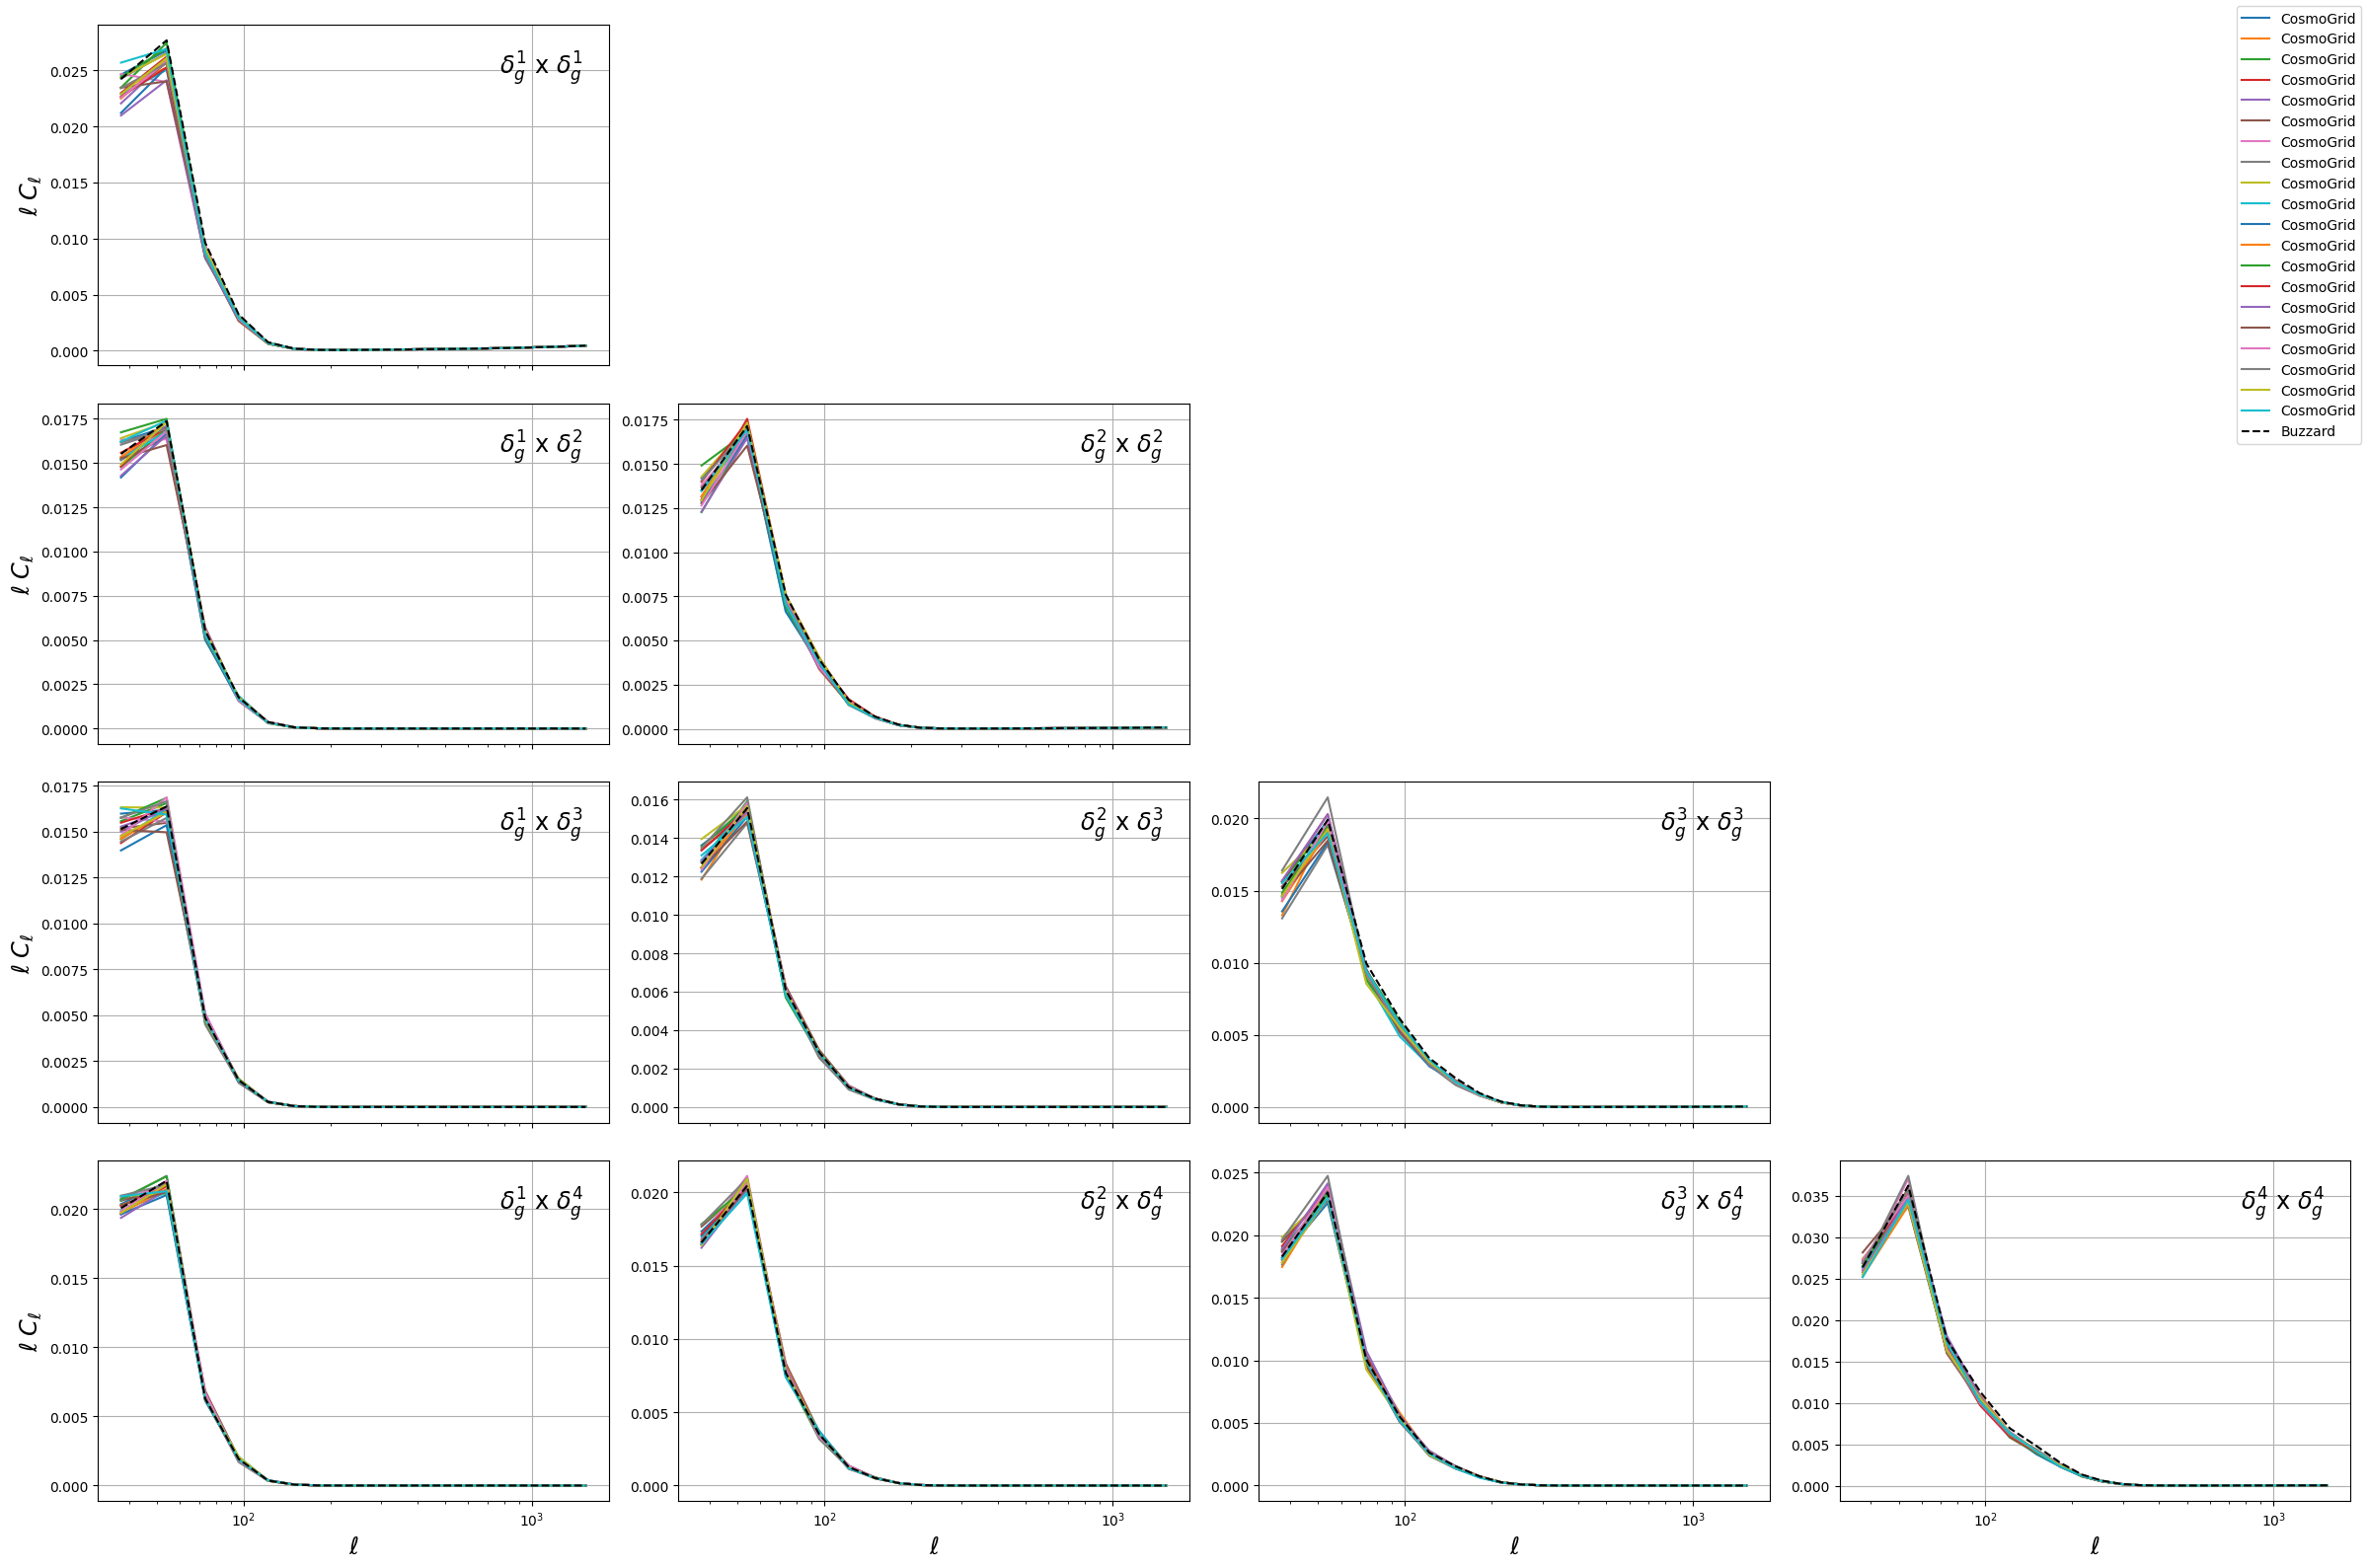

In [54]:
remove_l_min = True
figsize = (24, 16)
fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4

    current_bins = bins[1:]
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
    current_buzzard = buzzard_cls_reshaped[:, k]
    
    if remove_l_min:
        current_bins = bins[5:]
        current_cosmogrid = current_cosmogrid[4:]
        current_buzzard = current_buzzard[4:]
    else:
        current_bins = bins[1:]

    if i == 0:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0, label="CosmoGrid") 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--", label="Buzzard")
    else:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
    # label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # cosmetics
    ax[i, j].set_box_aspect(2 / 3)
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    if i == n_z - 1:
        ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# Turn off upper triangle
for i in range(n_z):
    for j in range(i + 1, n_z):
        ax[i, j].axis('off')

fig.legend()
fig.tight_layout()

# fig.savefig(f"plots/cls_test_Buzzard_{i_buzzard}.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_Buzzard_mean.png", bbox_inches="tight", dpi=100)
fig.savefig(f"plots/cls_test_Buzzard_stack.png", bbox_inches="tight", dpi=100)

# trash

In [2]:
temp = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid"

In [3]:
"grid" in temp

True

In [6]:
os.path.basename("/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial")

'cosmo_fiducial'